# Segmentation and Classification of Mammographic Images

In [1]:
# Daniel Vitor de Oliveira Santos, 716417, Ciência da Computação Coração Eucarístico
# Guilherme Cosso Lima Pimenta, gclpimenta@sga.pucminas.br, Ciência da Computação Coração Eucarístico
# Larissa Kaweski Siqueira, larissa.kaweski@sga.pucminas.br, Ciência da Computação Coração Eucarístico
# Imports
import pandas as pd
import numpy as np
import cv2
from pathlib import Path
import os.path
from fastai.vision.all import *
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPool2D, BatchNormalization, Reshape
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
from time import time

c:\Users\criss\AppData\Local\Programs\Python\Python37\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Benchmark CPU x GPU

In [18]:
# Create default model to test
def conv_model(device, filters, kz):
    with tf.device(device):
        model = Sequential()
        model.add(Conv2D(filters, kernel_size=3, padding='same', activation='relu', input_shape=(28, 28, 1)))
        model.add(MaxPool2D(pool_size=2))
        model.add(Conv2D(filters, kernel_size=3, padding='same', activation='relu'))
        model.add(MaxPool2D(pool_size=2))
        model.add(Conv2D(filters, kernel_size=3, padding='same', activation='relu'))
        model.add(MaxPool2D(pool_size=2))
        model.add(Flatten())
        model.add(Dense(10, activation='softmax'))

        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
        model.summary()

        return model

# Run model and compute time
def run(model, x_train, y_train, epochs=128, batch_size=32):
    start = time()
    model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size)
    end = time()

    return end - start

# Load dataset mnist
(x_train, y_train), (_, _) = mnist.load_data()

# Preprocessing data
x_train = x_train / 255.0 # Normalize
x_train = x_train.reshape(-1, 28, 28, 1) # Add the channel axis
y_train = to_categorical(y_train, num_classes=10) # Convert to one-hot encoding

# Define CPU and GPU models
cpu_model = conv_model('CPU', 64, 3)
gpu_model = conv_model('DML', 64, 3)

# Default hiperparams
epochs = 8
bz = 64

# Run models
conv_cpu_time = run(cpu_model, x_train, y_train, epochs=epochs, batch_size=bz)
conv_gpu_time = run(gpu_model, x_train, y_train, epochs=epochs, batch_size=bz)

# Computation time
print("Time to train with CPU:", conv_cpu_time)
print("Time to train with GPU:", conv_gpu_time)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 7, 7, 64)          36928     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 3, 3, 64)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 576)              

# Auxiliary Functions

In [2]:
# Get all data from a directory and return as a dataframe
def get_dataset(folder_path):
    folder = Path(folder_path)

    filepaths = list(folder.glob(r'**/*.png'))
    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

    filepaths = pd.Series(filepaths, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    return pd.concat([filepaths, labels], axis=1)

# Check if is multiple of 4
def is_multiple_of_4(number):
    number = number.split("(")[-1].split(")")[0]
    number = number.strip()
    return int(number) % 4 == 0

# Split dataframe into train and validation
def split_train_and_validation(dataset):
    images_train = dataset[~dataset['Filepath'].apply(is_multiple_of_4)]
    images_validation = dataset[dataset['Filepath'].apply(is_multiple_of_4)]

    print("Training set:")
    print("Quantity of samples:", len(images_train))
    print("Quantity of classes:", len(images_train['Label'].unique()))
    print()

    print("Validation set:")
    print("Quantity of samples:", len(images_validation))
    print("Quantity of classes:", len(images_validation['Label'].unique()))
    
    return images_train, images_validation

# Map labels based on initial
def map_label(label):
    if label.startswith('D'):
        return 'I'
    elif label.startswith('E'):
        return 'II'
    elif label.startswith('F'):
        return 'III'
    elif label.startswith('G'):
        return 'IV'
    else:
        return label
    
# Crop the image
def crop_image(image):
    # Get the dimensions of the image
    height, width = image.shape[:2]

    # Define the coordinates of the region of interest (ROI)
    x = 15
    y = 15
    crop_width = width - 30
    crop_height = height - 30
    
    return image[y:y+crop_height, x:x+crop_width]

# Find the optimal gamma for the image
def find_optimal_gamma(image):
    # Calculate average of pixels
    mean = np.mean(image)

    # Return the optimal gamma number for this image
    return np.log(mean) / np.log(512)

# Identify the largest object in the image
def biggest_object(image):
    # Perform labeling of connected components
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(image)

    # Find the index of the largest object (excluding the background)
    largest_label = np.argmax(stats[1:, cv2.CC_STAT_AREA]) + 1

    # Create a mask only for the largest object
    return np.uint8(labels == largest_label) * 255

# Segment a image
def segment_image(image):
    # Crop image, removing 15 pixels from the edges
    cropped = crop_image(image)
    
    # Set the ideal gamma
    gamma = find_optimal_gamma(image)
    
    # Apply gamma and Otsu transformation if necessary, otherwise apply only Threhold Binary
    if gamma >= 0.6:
        gamma_corrected = np.power(cropped / 255.0, gamma)
        image_filtered = np.uint8(gamma_corrected * 255)
        _, result = cv2.threshold(image_filtered, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    else:
        image_filtered = cropped
        _, result = cv2.threshold(image_filtered, 1, maxval=255, type=cv2.THRESH_BINARY)
        
    # Largest object in the image (breast)
    image_biggest = biggest_object(result)
    
    # Match the mask of the largest object with the original cropped image
    return cv2.bitwise_and(cropped, cropped, mask=image_biggest)

# Function to display images
def display_variations(filepaths):
    fig, axs = plt.subplots(1, 4, figsize=(15, 5))  # Create a figure with one row and four columns

    titles = ["Original Segmented", "Flipped", "Equalized", "Flipped Equalized"]

    for i, filepath in enumerate(filepaths):
        image = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
        axs[i].imshow(image, cmap='gray')
        axs[i].set_title(titles[i])  # Set the title based on the titles list
        
    plt.tight_layout()
    plt.show()

# Load Images into Dataframe

In [22]:
# Read images from directory
folder_path = './images/'
dataset = get_dataset(folder_path)
dataset

,Filepath,Label
0,images\DleftCC\d_left_cc (1).png,DleftCC
1,images\DleftCC\d_left_cc (10).png,DleftCC
2,images\DleftCC\d_left_cc (100).png,DleftCC
3,images\DleftCC\d_left_cc (101).png,DleftCC
4,images\DleftCC\d_left_cc (102).png,DleftCC
...,...,...
5019,images\GrightMLO\g_right_mlo (95).png,GrightMLO
5020,images\GrightMLO\g_right_mlo (96).png,GrightMLO
5021,images\GrightMLO\g_right_mlo (97).png,GrightMLO
5022,images\GrightMLO\g_right_mlo (98).png,GrightMLO


# Change Label

In [24]:
# Apply the function to the values ​​of "Label"
dataset['Label'] = dataset['Label'].apply(map_label)
dataset

,Filepath,Label
0,images\DleftCC\d_left_cc (1).png,I
1,images\DleftCC\d_left_cc (10).png,I
2,images\DleftCC\d_left_cc (100).png,I
3,images\DleftCC\d_left_cc (101).png,I
4,images\DleftCC\d_left_cc (102).png,I
...,...,...
5019,images\GrightMLO\g_right_mlo (95).png,IV
5020,images\GrightMLO\g_right_mlo (96).png,IV
5021,images\GrightMLO\g_right_mlo (97).png,IV
5022,images\GrightMLO\g_right_mlo (98).png,IV


In [25]:
# Disinct labels and count
dataset['Label'].value_counts()

I      1256
II     1256
III    1256
IV     1256
Name: Label, dtype: int64

# Finding the Best Segmentation

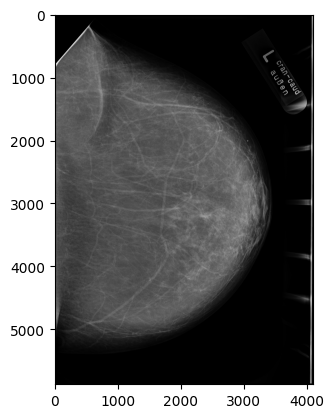

In [326]:
# Read an image and print
image = cv2.imread('.\images\DleftCC\d_left_cc (1).png', cv2.IMREAD_GRAYSCALE)
plt.imshow(image, cmap='gray')
plt.show()

0.6193667721821544


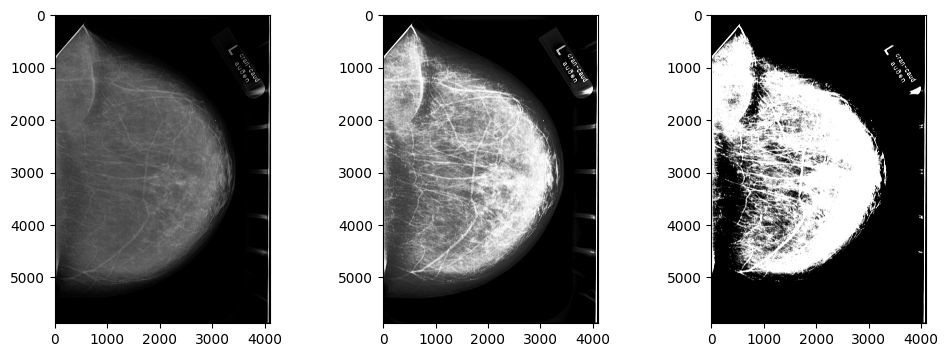

In [327]:
# Find the optimal gamma for the image
def find_optimal_gamma(image):
    mean = np.mean(image)
    return np.log(mean) / np.log(512)

def equalize_image(img):
    return cv2.equalizeHist(img)

gamma = find_optimal_gamma(image)
print(gamma)
equalized = equalize_image(image)

gamma_corrected = np.power(equalized / 255.0, gamma * 2)
image_filtered = np.uint8(gamma_corrected * 255)
_, result = cv2.threshold(image_filtered, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

fig,axes = subplots(1,3)
fig.set_size_inches([12, 4])
axes[0].imshow(image, cmap='gray')
axes[1].imshow(equalized, cmap='gray')
axes[2].imshow(result, cmap='gray')

0.6881045290130275


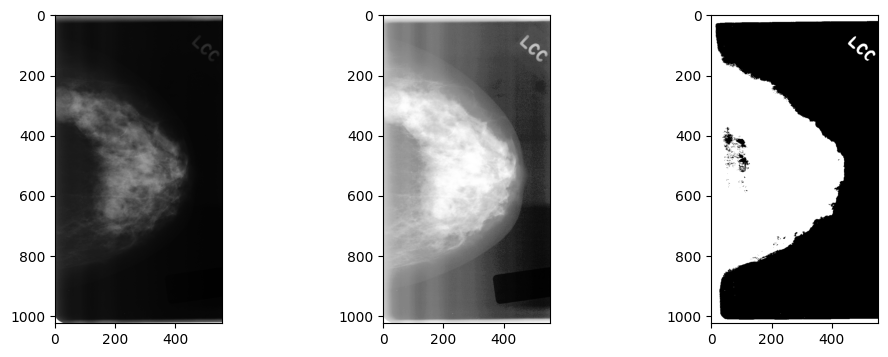

In [314]:
# Find the optimal gamma for the image
def find_optimal_gamma(image):
    mean = np.mean(image)
    return np.log(mean) / np.log(512)

def equalize_image(img):
    return cv2.equalizeHist(img)

gamma = find_optimal_gamma(image)
print(gamma)
equalized = equalize_image(image)

gamma_corrected = np.power(equalized / 255.0, gamma * 2)
image_filtered = np.uint8(gamma_corrected * 255)
_, result = cv2.threshold(image_filtered, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

fig,axes = subplots(1,3)
fig.set_size_inches([12, 4])
axes[0].imshow(image, cmap='gray')
axes[1].imshow(equalized, cmap='gray')
axes[2].imshow(result, cmap='gray')

In [128]:
def select_largest_obj(img_bin, lab_val=255, fill_holes=False, smooth_boundary=False, kernel_size=15):
    n_labels, img_labeled, lab_stats, _ = cv2.connectedComponentsWithStats(img_bin, connectivity=8, ltype=cv2.CV_32S)
    largest_obj_lab = np.argmax(lab_stats[1:, 4]) + 1
    largest_mask = np.zeros(img_bin.shape, dtype=np.uint8)
    largest_mask[img_labeled == largest_obj_lab] = lab_val
    if fill_holes:
        bkg_locs = np.where(img_labeled == 0)
        bkg_seed = (bkg_locs[0][0], bkg_locs[1][0])
        img_floodfill = largest_mask.copy()
        h_, w_ = largest_mask.shape
        mask_ = np.zeros((h_ + 2, w_ + 2), dtype=np.uint8)
        cv2.floodFill(img_floodfill, mask_, seedPoint=bkg_seed, newVal=lab_val)
        holes_mask = cv2.bitwise_not(img_floodfill)  # mask of the holes.
        largest_mask = largest_mask + holes_mask
    if smooth_boundary:
        kernel_ = np.ones((kernel_size, kernel_size), dtype=np.uint8)
        largest_mask = cv2.morphologyEx(largest_mask, cv2.MORPH_OPEN, kernel_)
        
    return largest_mask

v1 0.6852382391708087
v2: 71.86135096292038


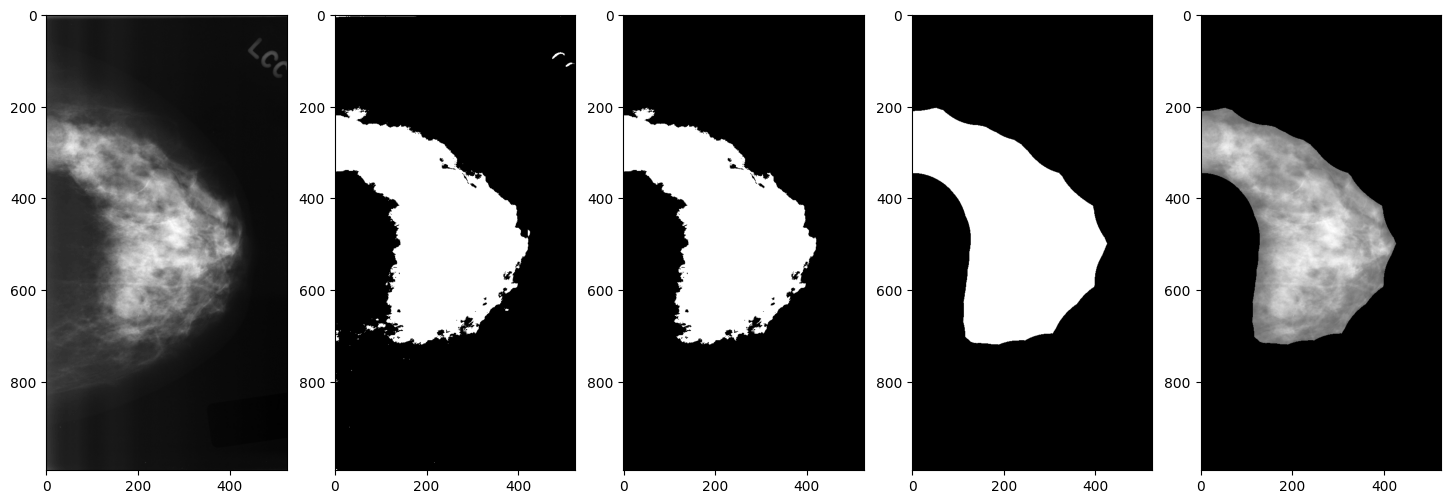

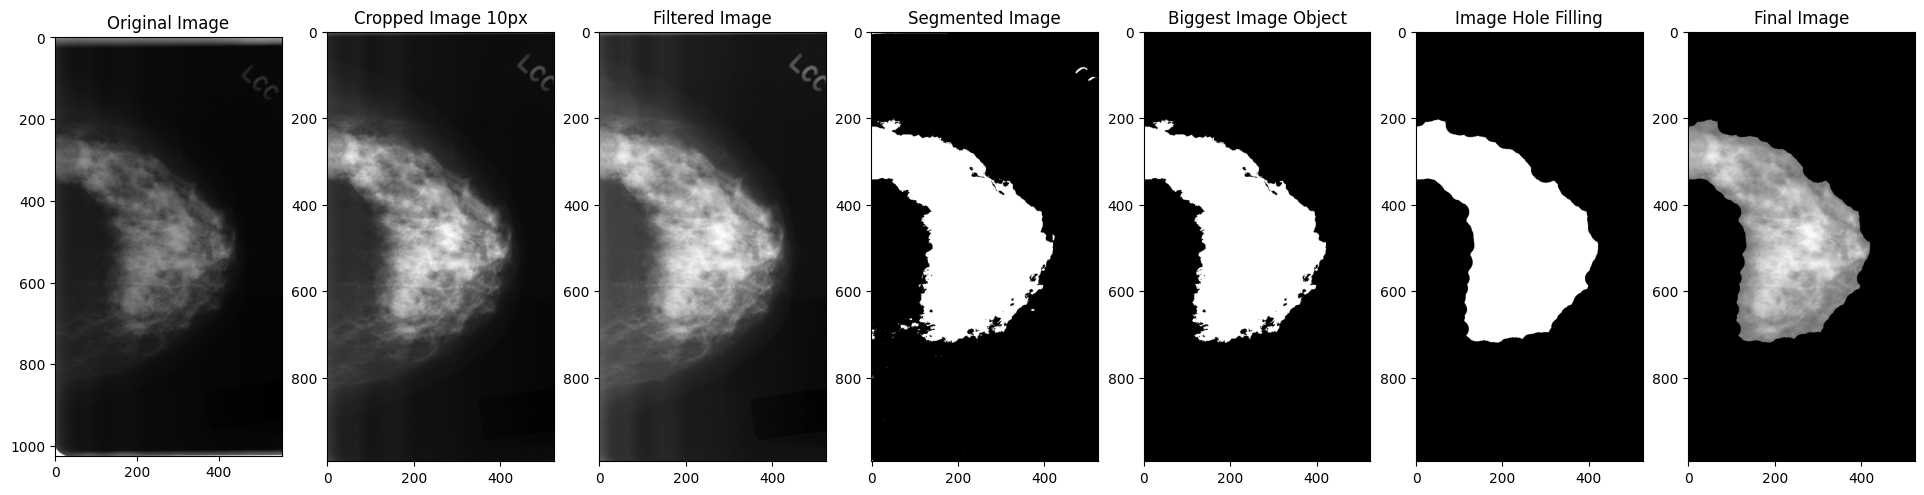

In [305]:
# Get the dimensions of the image
height, width = image.shape[:2]

# Define the coordinates of the region of interest (ROI)
x = 15
y = 15
crop_width = width - 30
crop_height = height - 30

# Crop
cropped = image[y:y+crop_height, x:x+crop_width]

# Find the optimal gamma for the image
def find_optimal_gamma(image):
    mean = np.mean(image)
    return np.log(mean) / np.log(512)

def teste(img):
    # Calculate histogram
    hist = cv2.calcHist([img], [0], None, [256], [0, 256])

    # Find the peak value in the histogram
    peak_value = np.argmax(hist)

    # Calculate the optimal gamma value
    return np.log10(128) / np.log10(peak_value)

gamma = find_optimal_gamma(cropped)
print("v1", gamma)
print("v2:", np.mean(cropped))

# Define threshold
threshold = 1

# Apply gamma
if gamma >= 0.6:
    if gamma >= 0.68 and np.mean(image) >= 100:
        gamma_corrected = np.power(cropped / 255.0, gamma / 8)
        image_filtered = np.uint8(gamma_corrected * 255)
        _, result = cv2.threshold(image_filtered, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    elif gamma >= 0.68 and np.mean(image) >= 70:
        gamma_corrected = np.power(cropped / 255.0, gamma / 2)
        image_filtered = np.uint8(gamma_corrected * 255)
        _, result = cv2.threshold(image_filtered, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    else:
        gamma_corrected = np.power(cropped / 255.0, gamma)
        image_filtered = np.uint8(gamma_corrected * 255)
        _, result = cv2.threshold(image_filtered, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
else:
    image_filtered = cropped
    _, result = cv2.threshold(image_filtered, threshold, maxval=255, type=cv2.THRESH_BINARY)

# Identify the largest object in the image
def biggest_object(image):
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(image)
    largest_label = np.argmax(stats[1:, cv2.CC_STAT_AREA]) + 1
    return np.uint8(labels == largest_label) * 255

def apply_hole_filling(image, disk_radius):
    # Create a structuring element (large disk)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2 * disk_radius + 1, 2 * disk_radius + 1))

    # Perform closing operation to fill holes
    return cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)

mask_img = biggest_object(result)  # <<= para to tune!
hole_filling = apply_hole_filling(mask_img, 110)
filtered_img = cv2.bitwise_and(cropped, cropped, mask=hole_filling)

fig,axes = subplots(1,5)
fig.set_size_inches([18, 9])
axes[0].imshow(cropped, cmap='gray')
axes[1].imshow(result, cmap='gray')
axes[2].imshow(mask_img, cmap='gray')
axes[3].imshow(hole_filling, cmap='gray')
axes[4].imshow(filtered_img, cmap='gray')

# Biggest object
biggest_object = biggest_object(result)

# Hole filling
image_hole_filling = apply_hole_filling(biggest_object, 20)

# Match the mask of the largest object with the original cropped image
final_image = cv2.bitwise_and(cropped, cropped, mask=image_hole_filling)

# Show images
plt.figure(figsize=(24, 12))
plt.subplot(1, 7, 1)
plt.imshow(image, cmap='gray')
plt.title("Original Image")
plt.subplot(1, 7, 2)
plt.imshow(cropped, cmap='gray')
plt.title("Cropped Image 10px")
plt.subplot(1, 7, 3)
plt.imshow(image_filtered, cmap='gray')
plt.title("Filtered Image")
plt.subplot(1, 7, 4)
plt.imshow(result, cmap='gray')
plt.title("Segmented Image")
plt.subplot(1, 7, 5)
plt.imshow(biggest_object, cmap='gray')
plt.title("Biggest Image Object")
plt.subplot(1, 7, 6)
plt.imshow(image_hole_filling, cmap='gray')
plt.title("Image Hole Filling")
plt.subplot(1, 7, 7)
plt.imshow(final_image, cmap='gray')
plt.title("Final Image")
plt.show()

# Test and Apply the Best Segmentation

Text(0.5, 1.0, 'Segmented Image')

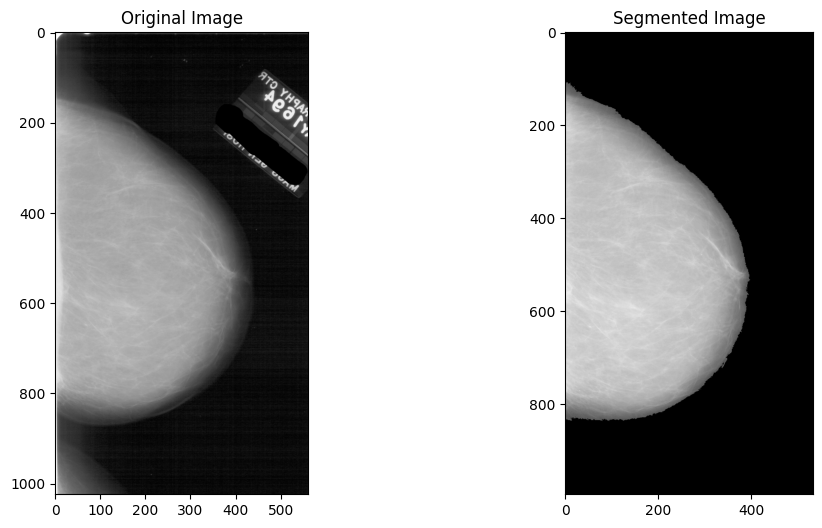

In [57]:
# Read image from directory
image_test = cv2.imread('./images/DleftCC/d_left_cc (313).png', cv2.IMREAD_GRAYSCALE)

# Segment image
segmented_image = segment_image(image_test)

# Show original image and segmented
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(image_test, cmap='gray')
plt.title("Original Image")
plt.subplot(1, 2, 2)
plt.imshow(segmented_image, cmap='gray')
plt.title("Segmented Image")

# Segmentation of All Images

In [55]:
# Source directory of the images
image_dir = 'images'

# Destination directory to save segmented images
segmented_dir = 'images_segmented_label'

# Check if the 'images_segmented_label' directory doesn't exist
if not os.path.exists(segmented_dir):
    # Read the CSV file with dataset_segmented information
    dataset_segmented = dataset

    # Create the destination directory
    os.makedirs(segmented_dir)

    # Create a copy of the original dataset_segmented
    dataset_segmented_segmented = dataset_segmented.copy()

    # Iterate over the rows of dataset_segmented_segmented
    for index, row in dataset_segmented_segmented.iterrows():
        # Get the image filepath
        image_filepath = row['Filepath']
        label = row['Label']

        # Read the image using OpenCV
        image = cv2.imread(image_filepath, cv2.IMREAD_GRAYSCALE)

        # Segment the image
        segmented_image = segment_image(image)

        # Get the destination directory for the segmented image based on the label
        label_dir = os.path.join(segmented_dir, label)

        # Create the label directory if it doesn't exist yet
        os.makedirs(label_dir, exist_ok=True)

        # Get the image name
        image_name = os.path.basename(image_filepath)

        # Get the complete path to save the segmented image
        segmented_filepath = os.path.join(label_dir, image_name)

        # Save the segmented image in the destination directory
        cv2.imwrite(segmented_filepath, segmented_image)
else:
    print("The 'images_segmented_label' directory already exists.")

The 'images_segmented_label' directory already exists.


# Load Images Segmented

In [3]:
# Read images from segmented directory
folder_path_segmented = './images_segmented_label/'
dataset_segmented = get_dataset(folder_path_segmented)
dataset_segmented

,Filepath,Label
0,images_segmented_label\I\d_left_cc (1).png,I
1,images_segmented_label\I\d_left_cc (10).png,I
2,images_segmented_label\I\d_left_cc (100).png,I
3,images_segmented_label\I\d_left_cc (101).png,I
4,images_segmented_label\I\d_left_cc (102).png,I
...,...,...
5019,images_segmented_label\IV\g_right_mlo (95).png,IV
5020,images_segmented_label\IV\g_right_mlo (96).png,IV
5021,images_segmented_label\IV\g_right_mlo (97).png,IV
5022,images_segmented_label\IV\g_right_mlo (98).png,IV


# Split Train and Validation

In [31]:
# Split dataset
_, test = split_train_and_validation(dataset_segmented)
test = test.sample(frac=1).reset_index(drop=True)
test

Training set:
Quantity of samples: 3776
Quantity of classes: 4

Validation set:
Quantity of samples: 1248
Quantity of classes: 4


,Filepath,Label
0,images_segmented_label\II\e_left_mlo (44).png,II
1,images_segmented_label\IV\g_left_cc (148).png,IV
2,images_segmented_label\II\e_right_cc (220).png,II
3,images_segmented_label\II\e_right_cc (16).png,II
4,images_segmented_label\III\f_left_mlo (160).png,III
...,...,...
1243,images_segmented_label\II\e_left_cc (276).png,II
1244,images_segmented_label\II\e_left_cc (44).png,II
1245,images_segmented_label\I\d_left_cc (120).png,I
1246,images_segmented_label\II\e_left_mlo (296).png,II


In [10]:
test['Label'].value_counts()

I      312
IV     312
III    312
II     312
Name: Label, dtype: int64

# Train Data Increase

In [65]:
train

,Filepath,Label
0,images_segmented_label\I\d_left_cc (1).png,I
1,images_segmented_label\I\d_left_cc (10).png,I
3,images_segmented_label\I\d_left_cc (101).png,I
4,images_segmented_label\I\d_left_cc (102).png,I
5,images_segmented_label\I\d_left_cc (103).png,I
...,...,...
5018,images_segmented_label\IV\g_right_mlo (94).png,IV
5019,images_segmented_label\IV\g_right_mlo (95).png,IV
5021,images_segmented_label\IV\g_right_mlo (97).png,IV
5022,images_segmented_label\IV\g_right_mlo (98).png,IV


In [66]:
# Diretório de saída para as imagens aumentadas
output_dir = "images_train_segmented_increased"

# Check if the 'images_train_segmented_increased' directory doesn't exist
if not os.path.exists(output_dir):

    # Verificar se o diretório de saída existe, caso contrário, criá-lo
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Função para realizar o aumento de dados e salvar as imagens
    def aumentar_dados(filepath, label):
        # Carregar a imagem original
        imagem = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
        
        # Espelhamento horizontal
        imagem_espelhada = cv2.flip(imagem, 1)
        
        # Equalização de histogramas
        imagem_equalizada = cv2.equalizeHist(imagem)
        imagem_espelhada_equalizada = cv2.equalizeHist(imagem_espelhada)
        
        # Salvar as imagens aumentadas
        cv2.imwrite(os.path.join(output_dir, label, os.path.basename(filepath)), imagem)
        cv2.imwrite(os.path.join(output_dir, label, os.path.basename(filepath).replace('.png', '_espelhada.png')), imagem_espelhada)
        cv2.imwrite(os.path.join(output_dir, label, os.path.basename(filepath).replace('.png', '_equalizada.png')), imagem_equalizada)
        cv2.imwrite(os.path.join(output_dir, label, os.path.basename(filepath).replace('.png', '_espelhada_equalizada.png')), imagem_espelhada_equalizada)

    # Aplicar o aumento de dados a cada imagem do dataset
    for index, row in train.iterrows():
        filepath = row['Filepath']
        label = row['Label']
        label_dir = os.path.join(output_dir, label)
        
        # Verificar se o diretório do Label existe, caso contrário, criá-lo
        if not os.path.exists(label_dir):
            os.makedirs(label_dir)
        
        # Realizar o aumento de dados e salvar as imagens
        aumentar_dados(filepath, label)
else:
    print("The 'images_train_segmented_increased' directory already exists.")

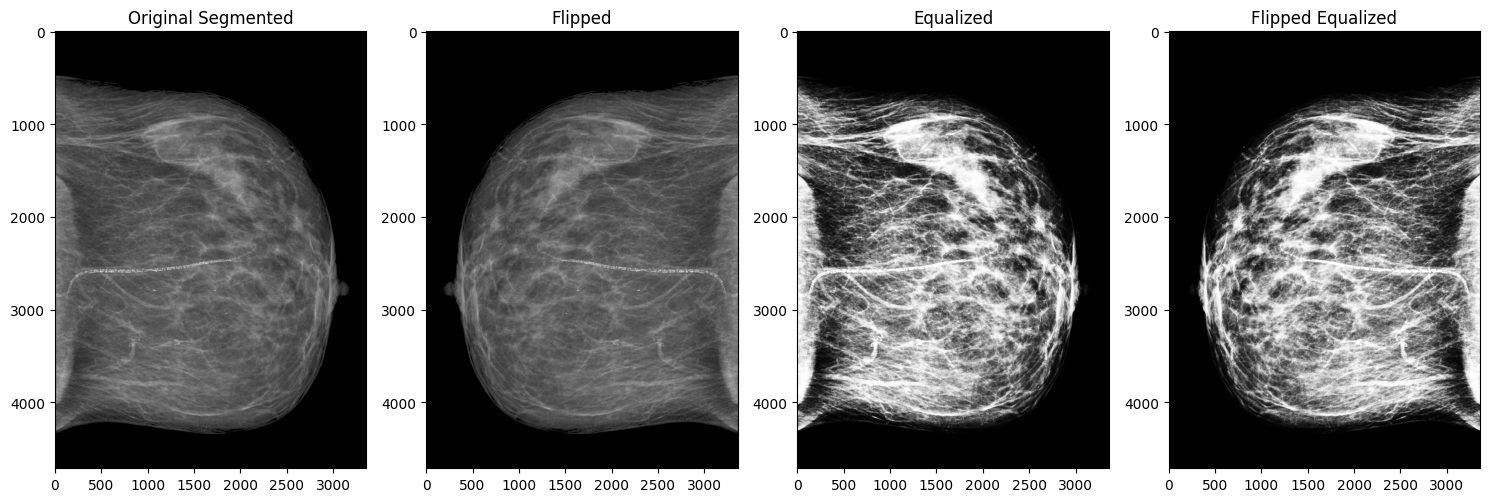

In [68]:
# Example of filepaths
filepaths = [
    'images_train_segmented_increased/I/d_left_cc (2).png',
    'images_train_segmented_increased/I/d_left_cc (2)_espelhada.png',
    'images_train_segmented_increased/I/d_left_cc (2)_equalizada.png',
    'images_train_segmented_increased/I/d_left_cc (2)_espelhada_equalizada.png'
]

# Show variations of images
display_variations(filepaths)

# Load Train Data Increased

In [30]:
# Read images from directory
folder_path_train_increased = './images_train_segmented_increased/'
train_segmented_increased = get_dataset(folder_path_train_increased)
train_segmented_increased = train_segmented_increased.sample(frac=1).reset_index(drop=True)
train_segmented_increased

,Filepath,Label
0,images_train_segmented_increased\II\e_left_cc (267)_espelhada_equalizada.png,II
1,images_train_segmented_increased\II\e_left_cc (183)_espelhada.png,II
2,images_train_segmented_increased\III\f_right_cc (225).png,III
3,images_train_segmented_increased\I\d_left_cc (58)_equalizada.png,I
4,images_train_segmented_increased\I\d_left_mlo (159)_espelhada_equalizada.png,I
...,...,...
15099,images_train_segmented_increased\III\f_left_cc (239)_equalizada.png,III
15100,images_train_segmented_increased\I\d_left_cc (290).png,I
15101,images_train_segmented_increased\IV\g_left_cc (1)_espelhada_equalizada.png,IV
15102,images_train_segmented_increased\IV\g_left_mlo (83)_espelhada_equalizada.png,IV


# Transform into 2 Classes

In [32]:
# Definir o dicionário de mapeamento para os labels
label_mapping = {'I': 'I', 'II': 'I', 'III': 'III', 'IV': 'III'}

# Substituir os valores dos labels
train_segmented_increased['Label'] = train_segmented_increased['Label'].map(label_mapping)
train_segmented_increased['Label'].value_counts()

I      7552
III    7552
Name: Label, dtype: int64

In [33]:
# Substituir os valores dos labels
test['Label'] = test['Label'].map(label_mapping)
test['Label'].value_counts()

I      624
III    624
Name: Label, dtype: int64

# Train and Validation Balancing

In [34]:
from sklearn.model_selection import train_test_split

# Separar os labels em classes diferentes
class_I = train_segmented_increased[train_segmented_increased['Label'] == 'I']
class_III = train_segmented_increased[train_segmented_increased['Label'] == 'III']

# Fazer o split para os dados de treino
train_I, val_I = train_test_split(class_I, train_size=0.8, random_state=42)
train_III, val_III = train_test_split(class_III, train_size=0.8, random_state=42)

# Concatenar as classes balanceadas
train_data = pd.concat([train_I, train_III])
validation_data = pd.concat([val_I, val_III])

# Embaralhar os dados
train_data = train_data.sample(frac=1, random_state=42).reset_index(drop=True)
validation_data = validation_data.sample(frac=1, random_state=42).reset_index(drop=True)

In [35]:
train_data['Label'].value_counts()

I      6041
III    6041
Name: Label, dtype: int64

In [36]:
validation_data['Label'].value_counts()

I      1511
III    1511
Name: Label, dtype: int64

# DataBlock of Images

In [37]:
# Image size
image_size = 224

# Datablock generator for images
generator = ImageDataGenerator(
    rescale=1./255
)

# Create datablock of train images
train_images = generator.flow_from_dataframe(
    dataframe=train_data,
    x_col="Filepath",
    y_col="Label", 
    target_size=(image_size, image_size),
    batch_size=32,
    class_mode='categorical',
    color_mode="rgb",
    shuffle=True,
    seed=42
)

# Create datablock of validation images
validation_images = generator.flow_from_dataframe(
    dataframe=validation_data,
    x_col="Filepath",
    y_col="Label", 
    target_size=(image_size, image_size),
    batch_size=32,
    class_mode="categorical",
    color_mode="rgb",
    shuffle=True,
    seed=42
)

# Create datablock of test images
test_images = generator.flow_from_dataframe(
    dataframe=test,
    x_col="Filepath",
    y_col="Label", 
    target_size=(image_size, image_size),
    batch_size=32,
    class_mode="categorical",
    color_mode="rgb",
    shuffle=False
)

# Print classes
print("Train classes:", train_images.class_indices)
print("Validation classes:", validation_images.class_indices)
print("Test classes:", test_images.class_indices)

Found 12082 validated image filenames belonging to 2 classes.
Found 3022 validated image filenames belonging to 2 classes.
Found 1248 validated image filenames belonging to 2 classes.
Train classes: {'I': 0, 'III': 1}
Validation classes: {'I': 0, 'III': 1}
Test classes: {'I': 0, 'III': 1}


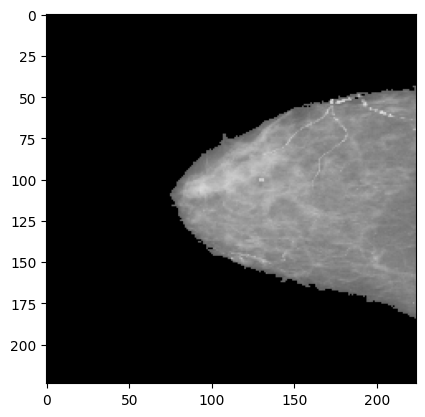

In [16]:
# Display image
image = test_images[4][0][0]

# Display the normalized image
plt.imshow(image)
plt.show()

# Create ResNet50 Model (GPU)

In [38]:
# Create the neural network model
def convolutional_model(base_model, device):
    with tf.device(device):
        model = Sequential()
        model.add(base_model)
        model.add(Dropout(0.2))
        model.add(Flatten())
        model.add(Dense(256, activation='relu'))
        model.add(Dropout(0.2))
        model.add(BatchNormalization())
        model.add(Dense(256, activation='relu'))
        model.add(Dropout(0.2))
        model.add(BatchNormalization())
        model.add(Dense(256, activation='relu'))
        model.add(Dropout(0.2))
        model.add(BatchNormalization())
        model.add(Dense(2, activation='softmax'))

        # Compile the model
        opt = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
        model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])

        # Print a summary of the model architecture
        model.summary()

        return model
    
# Load the ResNet50 model without the fully connected layers
base_model = ResNet50(weights='imagenet', pooling='avg', include_top=False, input_shape=(224, 224, 3))

# Freeze the weights of the base model to avoid training during fine-tuning
base_model.trainable = False

# Create ResNet50 model using AMD GPU
resnet50_model = convolutional_model(base_model, 'DML')

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dropout_12 (Dropout)         (None, 2048)              0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)               524544    
_________________________________________________________________
dropout_13 (Dropout)         (None, 256)               0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 256)               1024      
_________________________________________________________________
dense_13 (Dense)             (None, 256)              

# Model Callbacks

In [41]:
# Save best model and create early stop
cb_checkpointer = ModelCheckpoint(filepath='./best_segmented_2_classes.hdf5', save_weights_only=False, monitor='acc', save_best_only=True, mode='max')

# Fit Model

In [42]:
# Fit model with train and validation, and add callbacks
step_size_train = train_images.n//train_images.batch_size
step_size_validation = validation_images.n//validation_images.batch_size

resnet50_model.fit(
    train_images,
    validation_data=validation_images,
    epochs=30,
    callbacks=[cb_checkpointer],
    validation_steps=step_size_validation,
)
resnet50_model.load_weights("./best_segmented_2_classes.hdf5")                                                                                     

Epoch 1/30
378/378 [==============================] - 106s 281ms/step - loss: 0.3336 - acc: 0.8537 - val_loss: 2.2249 - val_acc: 0.4997
Epoch 2/30
378/378 [==============================] - 106s 281ms/step - loss: 0.3239 - acc: 0.8566 - val_loss: 1.5126 - val_acc: 0.5003
Epoch 3/30
378/378 [==============================] - 106s 281ms/step - loss: 0.3187 - acc: 0.8614 - val_loss: 3.2663 - val_acc: 0.5003
Epoch 4/30
378/378 [==============================] - 106s 280ms/step - loss: 0.3117 - acc: 0.8608 - val_loss: 1.3033 - val_acc: 0.4997
Epoch 5/30
378/378 [==============================] - 106s 279ms/step - loss: 0.3223 - acc: 0.8572 - val_loss: 4.8771 - val_acc: 0.4997
Epoch 6/30
378/378 [==============================] - 106s 280ms/step - loss: 0.3215 - acc: 0.8609 - val_loss: 2.2799 - val_acc: 0.4997
Epoch 7/30
378/378 [==============================] - 106s 280ms/step - loss: 0.3083 - acc: 0.8673 - val_loss: 3.0503 - val_acc: 0.5003
Epoch 8/30
378/378 [============================

# Load Model

In [43]:
resnet50_model.load_weights('./best_segmented_2_classes.hdf5')

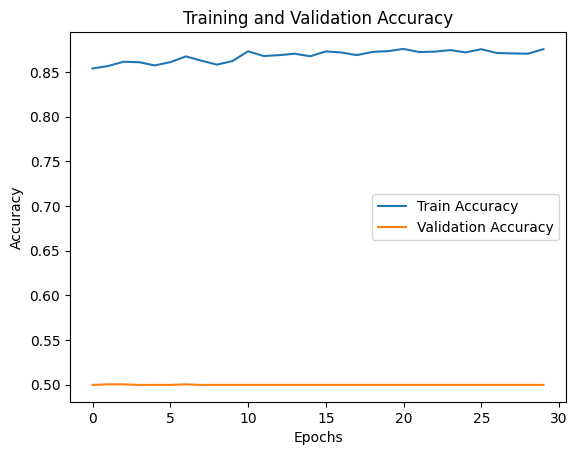

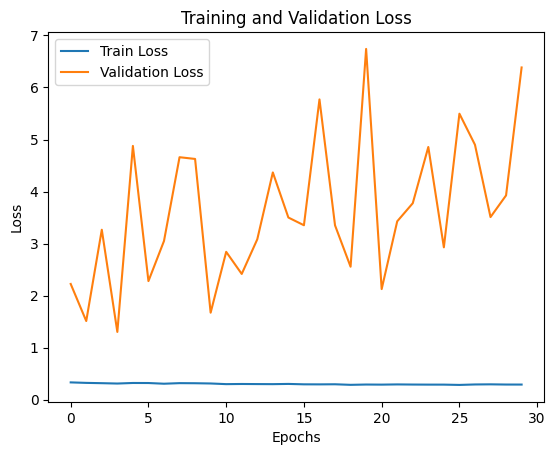

In [44]:
# Obter as métricas de treinamento
train_accuracy = resnet50_model.history.history['acc']
train_loss = resnet50_model.history.history['loss']

# Obter as métricas de validação
val_accuracy = resnet50_model.history.history['val_acc']
val_loss = resnet50_model.history.history['val_loss']

# Criar gráfico da acurácia
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Criar gráfico da perda
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


In [45]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# Definir o número total de amostras no conjunto de teste
num_samples = len(test_images.filenames)

# Fazer as previsões com o modelo usando o gerador
predictions = resnet50_model.predict_generator(test_images, steps=num_samples // test_images.batch_size)

# Converter as previsões em rótulos de classe
predicted_labels = np.argmax(predictions, axis=1)

# Obter os rótulos verdadeiros do gerador
true_labels = test_images.classes

# Calcular a acurácia usando o método evaluate_generator
_, accuracy = resnet50_model.evaluate_generator(test_images, steps=num_samples // test_images.batch_size)

# Calcular a precisão
precision = precision_score(true_labels, predicted_labels, average='weighted')

# Calcular a sensibilidade (recall)
recall = recall_score(true_labels, predicted_labels, average='weighted')

# Calcular o F1-score
f1 = f1_score(true_labels, predicted_labels, average='weighted')

# Calcular a matriz de confusão
confusion_mat = confusion_matrix(true_labels, predicted_labels)

# Calcular a especificidade
num_classes = confusion_mat.shape[0]
specificity = []

for i in range(num_classes):
    tn = np.sum(np.delete(np.delete(confusion_mat, i, axis=0), i, axis=1))
    fp = np.sum(np.delete(confusion_mat, i, axis=0)[:, i])
    specificity.append(tn / (tn + fp))

# Calcular a média da especificidade
average_specificity = np.mean(specificity)

# Imprimir as métricas
print(f"Accuracy: {round(accuracy * 100, 2)}%")
print(f"Precision: {round(precision * 100, 2)}%")
print(f"Recall (Sensibility): {round(recall * 100, 2)}%")
print(f"Mean Specificity: {round(average_specificity * 100, 2)}%")
print(f"F1-Score: {round(f1 * 100, 2)}%")

Accuracy: 50.0%
Precision: 25.0%
Recall (Sensibility): 50.0%
Mean Specificity: 50.0%
F1-Score: 33.33%


c:\Users\criss\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [24]:
from sklearn.metrics import confusion_matrix

# Prever as classes para o conjunto de testes
y_pred = resnet50_model.predict(test_images)
y_pred = np.argmax(y_pred, axis=1)

# Converter as classes verdadeiras em um array unidimensional
y_true = test_images.classes

# Calcular a matriz de confusão
confusion_mat = confusion_matrix(y_true, y_pred)

# Imprimir a matriz de confusão
print("Confusion Matrix:")
print(confusion_mat)

Confusion Matrix:
[[  0 624]
 [  0 624]]


In [26]:
from sklearn.metrics import confusion_matrix, classification_report

# Prever as classes para o conjunto de testes
y_pred = resnet50_model.predict(test_images)
y_pred = np.argmax(y_pred, axis=1)

# Converter as classes verdadeiras em um array unidimensional
y_true = test_images.classes

# Calcular a matriz de confusão
confusion_mat = confusion_matrix(y_true, y_pred)

report = classification_report(test_images.labels, y_pred, target_names=['I', 'III'], digits=4)
print(report)

              precision    recall  f1-score   support

           I     0.0000    0.0000    0.0000       624
         III     0.5000    1.0000    0.6667       624

    accuracy                         0.5000      1248
   macro avg     0.2500    0.5000    0.3333      1248
weighted avg     0.2500    0.5000    0.3333      1248



c:\Users\criss\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\criss\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\criss\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

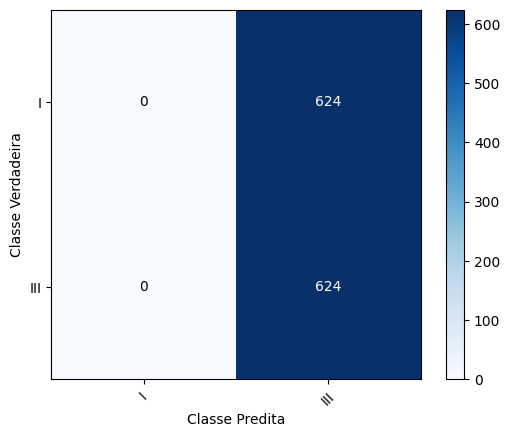

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Fazer as previsões com o modelo
y_pred = resnet50_model.predict(test_images)
y_pred_classes = np.argmax(y_pred, axis=1)

# Converter as classes verdadeiras em um array unidimensional
y_true = test_images.classes

# Calcular a matriz de confusão
cm = confusion_matrix(y_true, y_pred_classes)

# Definir as classes
classes = ['I', 'III']

# Plotar a matriz de confusão
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()

# Definir os rótulos dos eixos
plt.xlabel('Classe Predita')
plt.ylabel('Classe Verdadeira')

# Definir os rótulos das classes
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# Preencher a matriz com os valores
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

# Mostrar a matriz de confusão
plt.show()

# Testar o Modelo para 1 imagem

In [28]:
# Carregar a imagem
image_path = 'images_train_segmented_increased\IV\g_right_mlo (1).png'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Converter o padrão de cores para RGB
image = cv2.resize(image, (224, 224))  # Redimensionar a imagem para o tamanho esperado pelo modelo (224x224)
image = np.expand_dims(image, axis=0)  # Adicionar uma dimensão extra para representar o batch de imagens

# Pré-processar a imagem
image = preprocess_input(image)

# Predicao
predictions = resnet50_model.predict(image)

# Interpretar as previsões
class_names = ['I', 'III']
predicted_class = np.argmax(predictions[0])
predicted_label = class_names[predicted_class]

# Calcular a precisão da previsão
accuracy = predictions[0][predicted_class]

print('Previsão:', predicted_label)
print(f'Precisão: {round(accuracy * 100, 2)}%')

Previsão: III
Precisão: 100.0%


# Plot Model

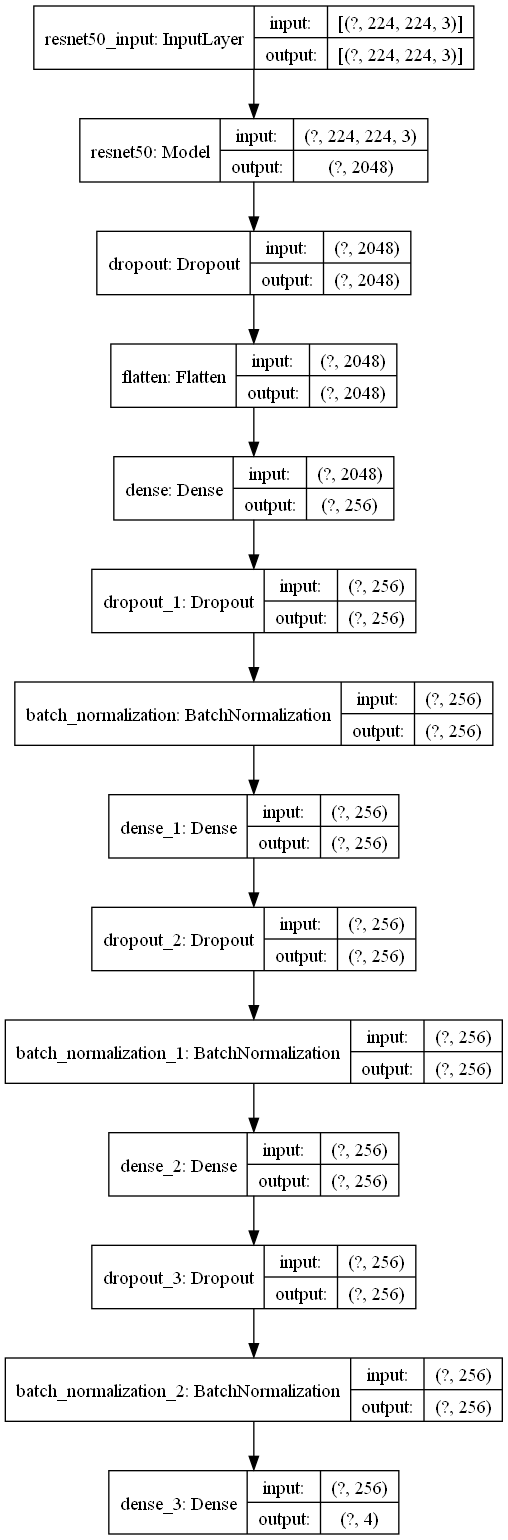

In [4]:
img_file = './model_arch.png'

tf.keras.utils.plot_model(resnet50_model, to_file=img_file, show_shapes=True, show_layer_names=True)